In [1]:
import torch
from fastai.vision import *
from zipfile import ZipFile
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import io
from pathlib import Path
warnings.simplefilter("ignore")

## Data Bunching

_______________________________________

In [2]:
from fastai.vision import *
path = Path('train_data/')
path.ls()


[WindowsPath('train_data/cleaned.csv'),
 WindowsPath('train_data/models'),
 WindowsPath('train_data/noMask'),
 WindowsPath('train_data/withMask')]

In [5]:
classes = ['noMask','withMask']
bs = 8
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224,bs=bs, num_workers=4).normalize(imagenet_stats)
data.classes

['noMask', 'withMask']

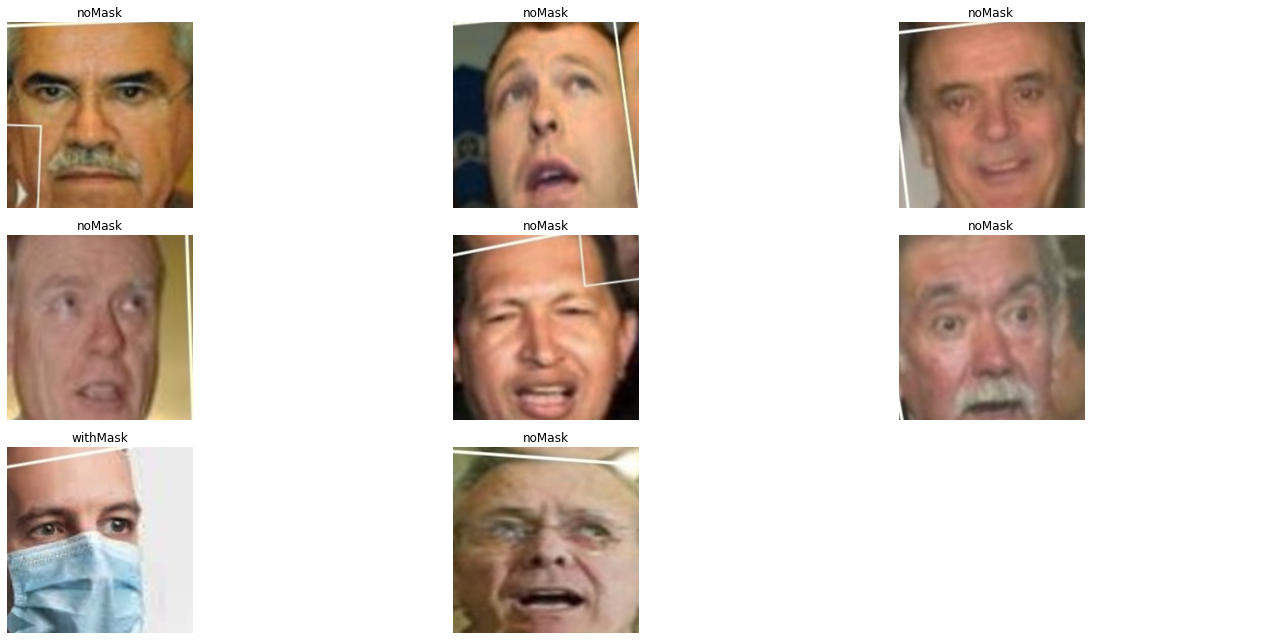

In [6]:
data.show_batch(rows=10, figsize=(20,9))

# Data Cleaning

_______________________________________

### Create a simple learner for data cleaning purposes

In [7]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [8]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.451308,0.034715,0.008097,01:16
1,0.258162,0.015975,0.000000,00:53


In [9]:
learn.save('stage-1')

In [10]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=128)
                   .databunch()
     )

In [11]:
db.classes

['noMask', 'withMask']

In [12]:
learn = cnn_learner(db, models.resnet34, metrics =[accuracy])

In [13]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1239 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
noMask,noMask,noMask,noMask,noMask
Path: train_data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: train_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

### Create a dataset and generate a list with top losses

In [14]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [15]:
#create a csv cleaned file
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Save cleaned dataset with top losses corrected

In [16]:
df = pd.read_csv(path/'cleaned.csv', header='infer')

### Generate dataset using cleaned top losses

In [17]:
np.random.seed(42)

In [20]:
db = (ImageList.from_df(df,path)
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch())

In [21]:
learn = cnn_learner(db, models.resnet34, metrics =error_rate)

In [22]:
learn = learn.load('stage-1')

### Generate dataset list that removes top similiarties

In [16]:
ds, idxs = DatasetFormatter().from_similars(learn, layer_ls=[0,7,1], pool = None)

Getting activations...


Computing similarities...


In [17]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :). 1139 pairs were skipped since at least one of the images was deleted by the user.'

# Start Modeling

_______________________________________

## Data Bunch the Cleaned Model

In [3]:
#USE ImageDataBunch fromList
classes = ['noMask','withMask']
np.random.seed(42)
bs=8
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv', 
                               ds_tfms=get_transforms(),bs=bs, size=228, num_workers=4).normalize(imagenet_stats)

In [4]:
data.classes

['noMask', 'withMask']

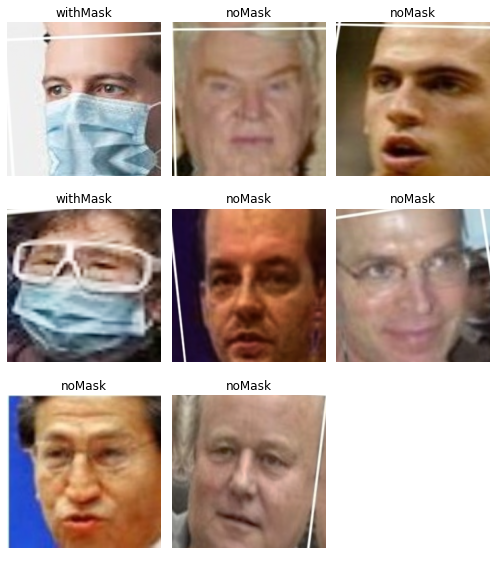

In [5]:
data.show_batch(rows=3, figsize=(7,8))

### Create Learner

In [6]:
learn_cln = cnn_learner(data, models.resnet34, metrics=error_rate)

### Train

In [7]:
learn_cln.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.490260,0.131202,0.044534,01:01
1,0.255420,0.015835,0.004049,00:58
2,0.192812,0.004983,0.000000,00:57
3,0.099060,0.002619,0.000000,00:58
4,0.076107,0.002862,0.000000,01:00


In [8]:
learn_cln.save('res34_stage1_v6')

In [24]:
learn_cln.save('res34_stage2_v6')

In [9]:
learn_cln.unfreeze()
#learn_cln.lr_find(start_lr=1e-30, end_lr=1e-1)
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


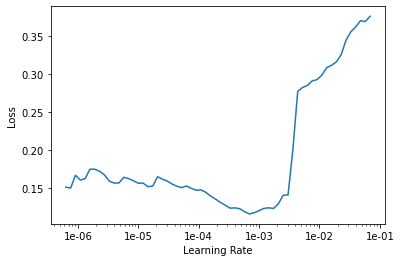

In [10]:
learn_cln.recorder.plot()

In [11]:
#learn_cln.fit_one_cycle(7)
learn_cln.fit_one_cycle(10,max_lr=slice(5e-3,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.166738,0.396656,0.060606,00:31
1,0.236979,4.580659,0.246753,00:31
2,0.222938,2.047937,0.129870,00:31
3,0.272482,2.644983,0.341991,00:31
4,0.269403,3.113298,0.090909,00:31
5,0.243971,0.112364,0.038961,00:31
6,0.221458,0.100056,0.034632,00:31
7,0.188090,0.079031,0.017316,00:31
8,0.165440,0.075969,0.012987,00:31
9,0.145769,0.073515,0.012987,00:31


In [12]:
learn_cln.save('res34_stage2_v3')

## Interpret Losses

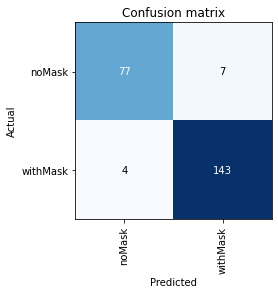

In [11]:
interp = ClassificationInterpretation.from_learner(learn_cln)
interp.plot_confusion_matrix()

In [12]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

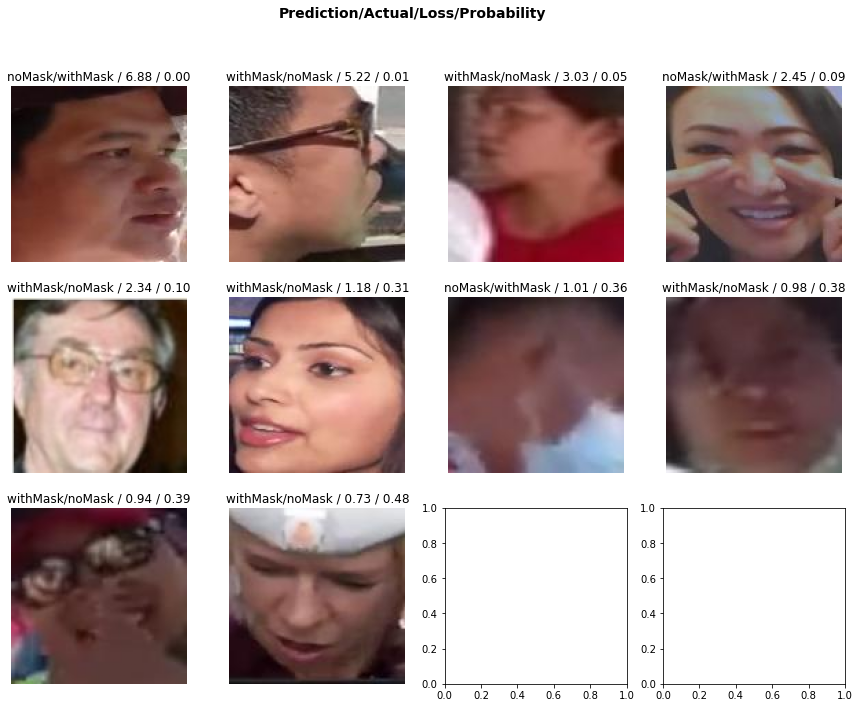

In [13]:
interp.plot_top_losses(10, figsize=(15,11))

## Tuning the Model

### Delete erroneous

In [3]:
####
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
    .split_none()
    .label_from_df()
    .transform(get_transforms(), size=224)#                    
    .databunch()
    )

In [6]:

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('res34_stage2_v3');

In [7]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

NameError: name 'DatasetFormatter' is not defined

In [53]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [48]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


#                                                    """"""""""""""""""""""""SavingModel"""""""""""""""""""

## 1. Method 1 - Manual changing of head

In [13]:
learn_mn.save('mn_stage2')  #Might not be saving dictionary here

In [100]:
#Open the fastai notebook you used for training and save the weights in the following unorthodox manner:
torch.save({'state_dict': learn_mn.model.state_dict()}, 'data/models/mn_dict.pth')
#torch.save(learn_mn.model.state_dict(), 'data/models/mn_dict.pth')

## 2. Method 2 - Load through FastAI 

In [19]:
learn_mn.export()

#                                                    """"""""""""""""""""""""Loading Model"""""""""""""""""""

## 1. Method 1 - Manual changing of head

## 2. Method 2 - Load through FastAI 

### Creating your data bunch



In [24]:
import torchvision
from fastai.vision import *
classes = ['noMask','withMask']
path = 'data'
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=128).normalize(imagenet_stats)

learn = cnn_learner(data2, models.resnet34, metrics=error_rate)

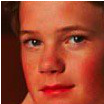

In [11]:
defaults.device = torch.device('cpu')
#img = open_image('D:/Projects/Mask Detector/misc/images/2.png')
img = open_image('D:/Projects/Mask Detector/misc/images/6.png')
img

In [26]:
    learn.load('res34_stage2_1');
# OR
#learn_mn = load_learner(path, file = 'export.pkl')

In [35]:
import time


tic= time.time() 
pred_class,pred_idx,outputs = learn.predict(img)
toc=time.time()
print(toc-tic)
pred_class



0.11308050155639648


Category noMask

## Testing Modules

### Capture a Photo or start a stream

In [7]:
import cv2
from imutils.video import VideoStream
import imutils
import time
import numpy as np

vs = VideoStream(src=1).start()
time.sleep(2.0)

def startstream():
    while True:
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

def capturephoto(vs):
    while(True):
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        cv2.imshow('img1',frame) #display the captured image
        if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
            cv2.imwrite('D:/Projects/Mask Detector/misc/images/c2.png',frame)
            cv2.destroyAllWindows()
            break
    vs.stream.release()
    
capturephoto(vs)

AttributeError: 'WebcamVideoStream' object has no attribute 'release'

### Crop Face and save

In [19]:
import os
import cv2
def facecrop(image):
    global i
    facedata = "haarcascade_frontalface_alt.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)
    if img.size == 0:
        print('no image')

    minisize = (img.shape[1],img.shape[0])
    miniframe = cv2.resize(img, minisize)
    print(minisize)
    
    faces = cascade.detectMultiScale(miniframe)

    for f in faces:
        i = i+1
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

        sub_face = img[y:y+h, x:x+w]
        fname, ext = os.path.splitext(image)
        fname = os.path.split(image)
        save_dest = os.path.join(str(fname[0]),str(i)+ext)
        
        #cv2.imwrite(fname+"_cropped_"+ext, sub_face)
        cv2.imwrite(save_dest, sub_face)
        print(save_dest)
    return


In [21]:

i =1 
replace = False
plot = True

file_dir = 'D:/Projects/Mask Detector/misc/images'
for filename in os.listdir(file_dir):
    img_path  = os.fsdecode(filename)
    img_path = file_dir +'/'+ img_path
    print(img_path)
    if filename.endswith('.png'):
        
        #image = imageio.imread(img_path)
        facecrop(img_path)


D:/Projects/Mask Detector/misc/images/.ipynb_checkpoints
D:/Projects/Mask Detector/misc/images/1.jpg
D:/Projects/Mask Detector/misc/images/2.jpg
D:/Projects/Mask Detector/misc/images/3.jpg
D:/Projects/Mask Detector/misc/images/4.jpg
D:/Projects/Mask Detector/misc/images/adrian.png
(645, 584)
D:/Projects/Mask Detector/misc/images\2.png
D:/Projects/Mask Detector/misc/images\3.png
D:/Projects/Mask Detector/misc/images/c1.png
(400, 300)
D:/Projects/Mask Detector/misc/images\4.png
D:/Projects/Mask Detector/misc/images/c2.png
(400, 300)
D:/Projects/Mask Detector/misc/images\5.png
D:/Projects/Mask Detector/misc/images/neil_patrick_harris.png
(570, 389)
D:/Projects/Mask Detector/misc/images\6.png
D:/Projects/Mask Detector/misc/images/sachin.jpg
D:/Projects/Mask Detector/misc/images/samuel_l_jackson.png
(512, 512)
D:/Projects/Mask Detector/misc/images\7.png


## Testing a Caffe Model